### 데이터 명세

- id : 해당 데이터의 고유한 ID (train, test와의 중복은 없음)

- date  : 날짜

- bus_route_id : 노선 id

- in_out  : 시내버스, 시외버스 구분 (categorical)

- station_code : 해당 승하차 정류소의 ID

- station_name : 해당 승하차 정류소의 이름

- latitude : 해당 버스 정류장의 위도 

- longitude : 해당 버스 정류장의 경도 

### *** 같은 위도경도여도 진행 방향에 따라 정류장이 다를수 있음.

- X-Y ride : 00:00부터 59:59까지 승차한 인원수

- X-Y takeoff : 00:00부터 59:59까지 하차한 인원수

- 18-20 ride : 18:00:00부터 19:59:59까지 승차한 인원 수 (train data에만 존재, 예측해야할 target) 


In [1]:
import numpy as np 
import pandas as pd 
import datetime

# 결측값 유무 
import missingno as msno 

import warnings #경고 미출력
warnings.filterwarnings('ignore')
from collections import Counter # count

import matplotlib.pyplot as plt 
import seaborn as sns

# 지도 관련 시각화 
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

#데이터 샘플링
import random
from sklearn.preprocessing import LabelEncoder #인코딩
from sklearn.preprocessing import OneHotEncoder

#validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 

#model
import lightgbm as lgbm 

#processing bar
from tqdm import tqdm_notebook

In [2]:
train = pd.read_csv('train.csv',parse_dates=['date'])
test = pd.read_csv('test.csv',parse_dates=['date'])

In [3]:
print(train.shape)
print(test.shape)

(415423, 21)
(228170, 20)


In [4]:
train.info()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  object        
 4   station_code   415423 non-null  int64         
 5   station_name   415423 non-null  object        
 6   latitude       415423 non-null  float64       
 7   longitude      415423 non-null  float64       
 8   6~7_ride       415423 non-null  float64       
 9   7~8_ride       415423 non-null  float64       
 10  8~9_ride       415423 non-null  float64       
 11  9~10_ride      415423 non-null  float64       
 12  10~11_ride     415423 non-null  float64       
 13  11~12_ride     415423 non-null  float64       
 14  6~7_takeoff    415423 non-null  float64       
 15  

In [5]:
print(train.columns)
print(test.columns)

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')
Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'],
      dtype='object')


In [6]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
train.describe()

,id,bus_route_id,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
count,415423.000000,4.154230e+05,4.154230e+05,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000
mean,207711.000000,2.691935e+07,4.209311e+04,33.420375,126.533574,0.305893,0.829699,0.815350,0.642475,0.599618,0.579393,0.112870,0.344870,0.516481,0.430922,0.408001,0.402874,1.242095
std,119922.434776,3.924652e+06,4.971504e+05,0.107996,0.140986,1.109766,2.255116,2.317561,1.959844,1.885941,1.942137,0.597714,1.279179,1.658850,1.485124,1.412839,1.446080,4.722287
min,0.000000,4.270000e+06,1.000000e+00,33.208350,126.165040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,103855.500000,2.346000e+07,3.200000e+02,33.291080,126.475780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,207711.000000,2.803000e+07,1.130000e+03,33.478850,126.529770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,311566.500000,3.003000e+07,2.226000e+03,33.500020,126.575890,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,415422.000000,3.282000e+07,6.115101e+06,33.963640,126.965670,85.000000,94.000000,136.000000,78.000000,124.000000,99.000000,45.000000,66.000000,59.000000,65.000000,52.000000,81.000000,272.000000


In [9]:
set(train.columns)-set(test.columns)

{'18~20_ride'}

### 요일, 휴일 별 승하차량

In [10]:
train['weekday'] = train['date'].dt.weekday
test['weekday'] = test['date'].dt.weekday

In [11]:
# holiday(공휴일), weekend(주말)
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]
# holiday이면 Y 아니면 N
train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in [5,6] else row.holiweekend, axis=1)


test['holiday'] = test.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
test['holiweekend'] = test.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
test['holiweekend'] = test.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in [5,6] else row.holiweekend, axis=1)

In [12]:
train['holiweekend']

0         WE
1         WE
2         WE
3         WE
4         WE
          ..
415418     N
415419     N
415420     N
415421     N
415422     N
Name: holiweekend, Length: 415423, dtype: object

In [13]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', 'holiday', 'holiweekend'],
      dtype='object')

### 승하차 시간 통합/ 시간대별 평균(새벽, 아침, 정오)

In [14]:
train['68a'] = train['6~7_ride']+train['7~8_ride']
train['810a'] = train['8~9_ride']+train['9~10_ride']
train['1012a'] = train['10~11_ride']+train['11~12_ride']

train['68b'] = train['6~7_takeoff']+train['7~8_takeoff']
train['810b'] = train['8~9_takeoff']+train['9~10_takeoff']
train['1012b'] = train['10~11_takeoff']+train['11~12_takeoff']

In [15]:
test['68a'] = test['6~7_ride']+test['7~8_ride']
test['810a'] = test['8~9_ride']+test['9~10_ride']
test['1012a'] = test['10~11_ride']+test['11~12_ride']

test['68b'] = test['6~7_takeoff']+test['7~8_takeoff']
test['810b'] = test['8~9_takeoff']+test['9~10_takeoff']
test['1012b'] = test['10~11_takeoff']+test['11~12_takeoff']

Text(0.5, 1.0, 'Ride & Takeoff COR')

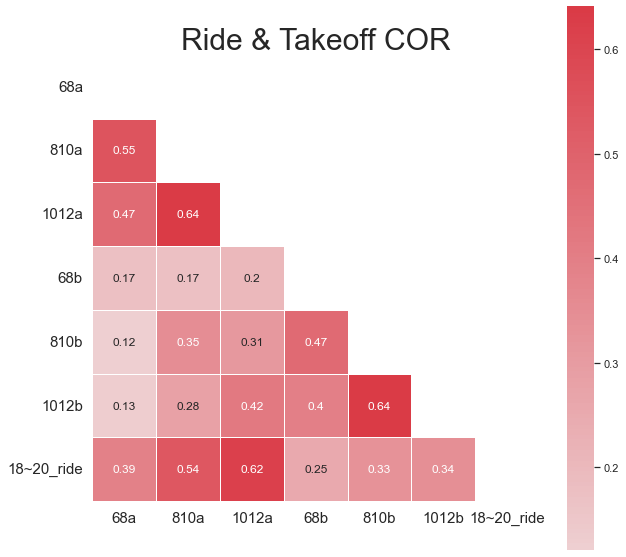

In [16]:
train_df = train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor = train_df.corr()

sns.set(style='white')
mask = np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=15)
plt.yticks(size=15,rotation=0)
plt.title("Ride & Takeoff COR",size=30)

#### 10-12가 상관관계 높음

In [17]:
#3가지 시간대로 나눔 : 새벽, 아침, 정오
dawn_ride_cols, dawn_takoff_cols = ['6~7_ride','7~8_ride'], ['6~7_takeoff','7~8_takeoff']
morning_ride_cols, morning_takeoff_cols = ['8~9_ride','9~10_ride'], ['8~9_takeoff','9~10_takeoff']
noon_ride_cols, noon_takeoff_cols = ['10~11_ride','11~12_ride'], ['10~11_takeoff','11~12_takeoff']

def divide_time(df):
    # 승차
    df['dawn_ride'] = df[dawn_ride_cols].sum(axis=1) #새벽
    df['morning_ride'] = df[morning_ride_cols].sum(axis=1) #아침
    df['noon_ride'] = df[noon_ride_cols].sum(axis=1) #정오
    
    # 하차
    df['dawn_takeoff'] = df[dawn_takoff_cols].sum(axis=1)
    df['morning_takeoff'] = df[morning_takeoff_cols].sum(axis=1)
    df['noon_takeoff'] = df[noon_takeoff_cols].sum(axis=1)
    
    # 임의 컬럼 삭제
    drop_cols = dawn_ride_cols + morning_ride_cols + noon_ride_cols + dawn_takoff_cols + morning_takeoff_cols + noon_takeoff_cols
    df = df.drop(drop_cols, 1)
    
    return df

In [18]:
train = divide_time(train)
test = divide_time(test)

In [19]:
# 탑승

train['avg_dawn_ride'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
train['avg_morning_ride'] = train.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
train['avg_noon_ride'] = train.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

test['avg_dawn_ride'] = test.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
test['avg_morning_ride'] = test.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
test['avg_noon_ride'] = test.groupby(['date','bus_route_id'])['noon_ride'].transform('mean')  

In [20]:
# 하차

train['avg_dawn_takeoff'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
train['avg_morning_takeoff'] = train.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
train['avg_noon_takeoff'] = train.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

test['avg_dawn_takeoff'] = test.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
test['avg_morning_takeoff'] = test.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
test['avg_noon_takeoff'] = test.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean')

### Categorical variable

In [21]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,weekday,...,noon_ride,dawn_takeoff,morning_takeoff,noon_takeoff,avg_dawn_ride,avg_morning_ride,avg_noon_ride,avg_dawn_takeoff,avg_morning_takeoff,avg_noon_takeoff
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,6,...,8.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,5.0,6,...,11.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,6,...,0.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,53.0,6,...,30.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,6,...,0.0,0.0,1.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88


In [22]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [23]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
train_cat = ohe.fit_transform(train[['weekday']])
test_cat = ohe.fit_transform(test[['weekday']])

In [24]:
lbl = LabelEncoder()

cat_cols = ['bus_route_id', 'station_code', 'station_name', 'holiday', 'holiweekend']

for col in tqdm_notebook(cat_cols):
    lbl.fit(train[col])
    train[col] = lbl.transform(train[col])
    
for col in tqdm_notebook(cat_cols):
    lbl.fit(test[col])
    test[col] = lbl.transform(test[col])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
target = '18~20_ride'
train_label = train[target]

train = train.drop(['id','date','latitude','longitude'], axis=1)
test = test.drop(['id','date','latitude','longitude'], axis=1)

In [27]:
train = train.drop('18~20_ride', axis=1)

In [28]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))
lgbm_oof_test = np.zeros((test.shape[0]))

# Hyperparameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 10000
SEED = 777
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':777,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

# Kfold 
kfolds = KFold(n_splits=n_splits, random_state=777, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook(enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의
    X_train , y_train = train.iloc[trn_ind], train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind], train_label[val_ind]
    
    # Light GBM
    print("---TRAINING---")
    
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits #Fold한 결과 앙상블(평균)

0it [00:00, ?it/s]

---TRAINING---
[LightGBM] [Warning] seed is set=777, random_state=777 will be ignored. Current value: seed=777
[LightGBM] [Warning] seed is set=777, random_state=777 will be ignored. Current value: seed=777
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 332338, number of used features: 24
[LightGBM] [Warning] seed is set=777, random_state=777 will be ignored. Current value: seed=777
[LightGBM] [Info] Start training from score 1.232011
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 4.98068	valid's l2: 7.79807
[200]	train's l2: 3.91299	valid's l2: 7.44683
[300]	train's l2: 3.36122	valid's l2: 7.2593
[400]	train's l2: 2.96159	valid's l2: 7.13289
[500]	train's l2: 2.65655	valid's l2: 7.049

In [29]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print(f"<Light-GBM> OVERALL RMSE: {sqrt( mean_squared_error( train_label, lgbm_oof_train ))}")

<Light-GBM> OVERALL RMSE: 2.539965099147722
